# Comparing SDO/AIA Response Functions: SSW and SunPy
This notebook runs comparisons between the results of SSW and SunPy in calculating the wavelength and temperature response functions of the AIA instrument on board SDO.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sunpy.instr.aia
%matplotlib inline

## Wavelength Response

First, load the SSW results into some convenient data structure.

In [2]:
data = np.loadtxt('../aia_sample_data/aia_wresponse_raw.dat')
channels = [94,131,171,193,211,304,335]
ssw_results = {}
for i in range(len(channels)):
    ssw_results[channels[i]] = {'wavelength':data[:,0],
                                'response':data[:,i+1]}

Run the SunPy calculation.

In [3]:
response = sunpy.instr.aia.Response(path_to_genx_dir='../ssw_aia_response_data/')
response.calculate_wavelength_response()

Plot the results against each other.

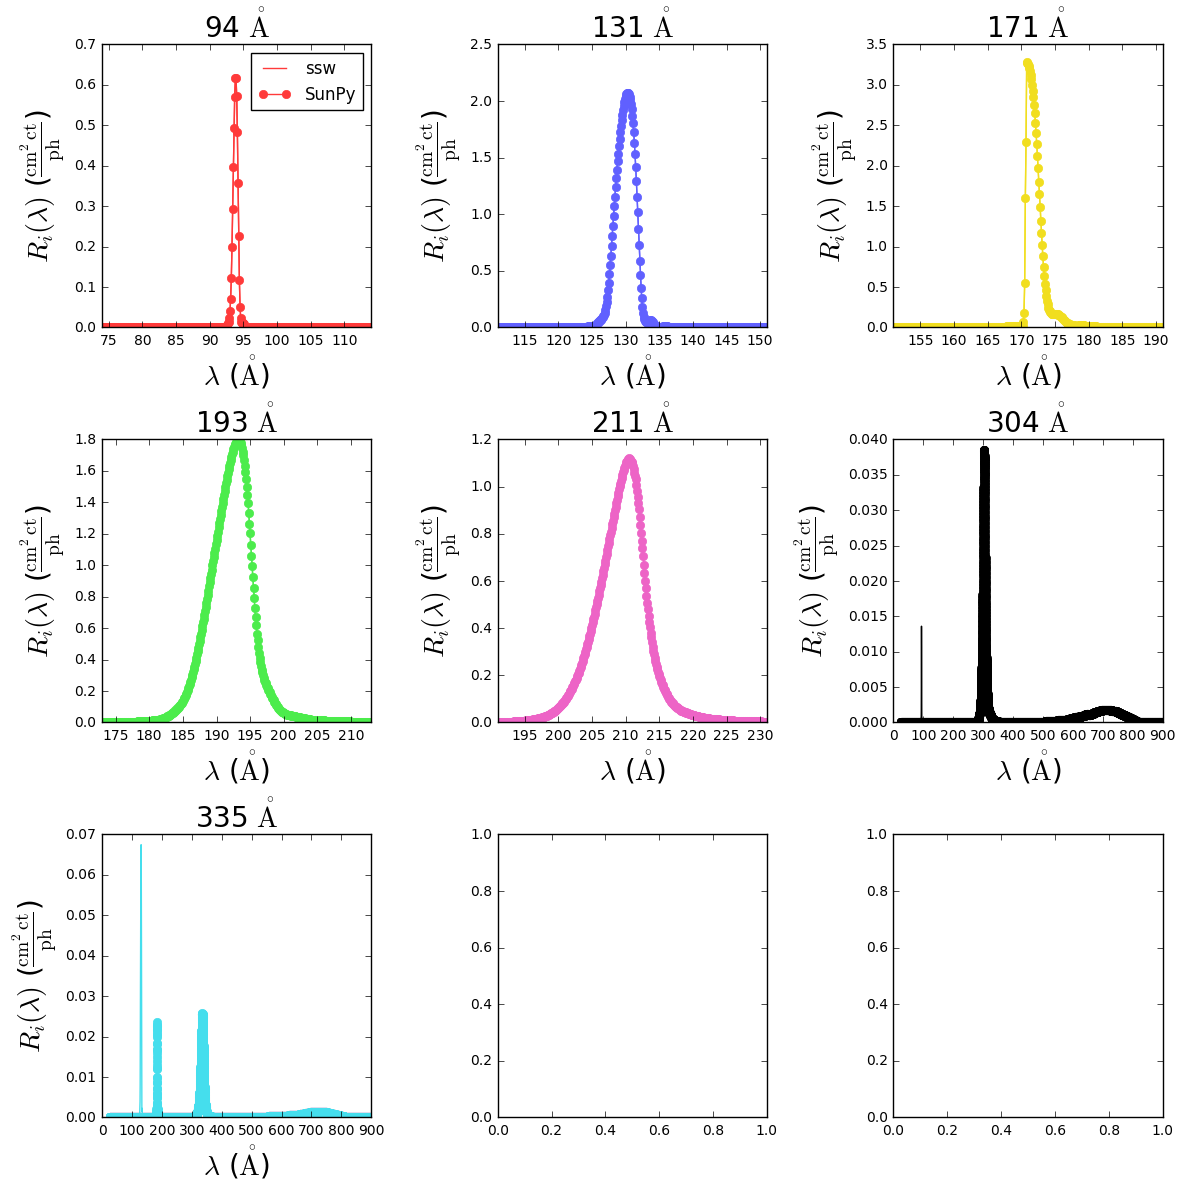

In [12]:
fig,axes = plt.subplots(3,3,figsize=(12,12))
for c,ax in zip(channels,axes.flatten()):
    #ssw
    ax.plot(ssw_results[c]['wavelength'],ssw_results[c]['response'],
           color=response.channel_colors[c],label='ssw')
    #sunpy
    ax.plot(response.wavelength_response[c]['wavelength'],response.wavelength_response[c]['response'],
        color=response.channel_colors[c],marker='.',ms=12,label='SunPy')
    if c!=335 and c!=304:
        ax.set_xlim([c-20,c+20])
    ax.set_title('{} $\mathrm{{\mathring{{A}}}}$'.format(c),fontsize=20)
    ax.set_xlabel(r'$\lambda$ ({0:latex})'.format(response.wavelength_response[c]['wavelength'].unit),fontsize=20)
    ax.set_ylabel(r'$R_i(\lambda)$ ({0:latex})'.format(response.wavelength_response[c]['response'].unit),fontsize=20)
axes[0,0].legend(loc='best')
plt.tight_layout()

Now, do a "residual plot" of the differences between the two results.

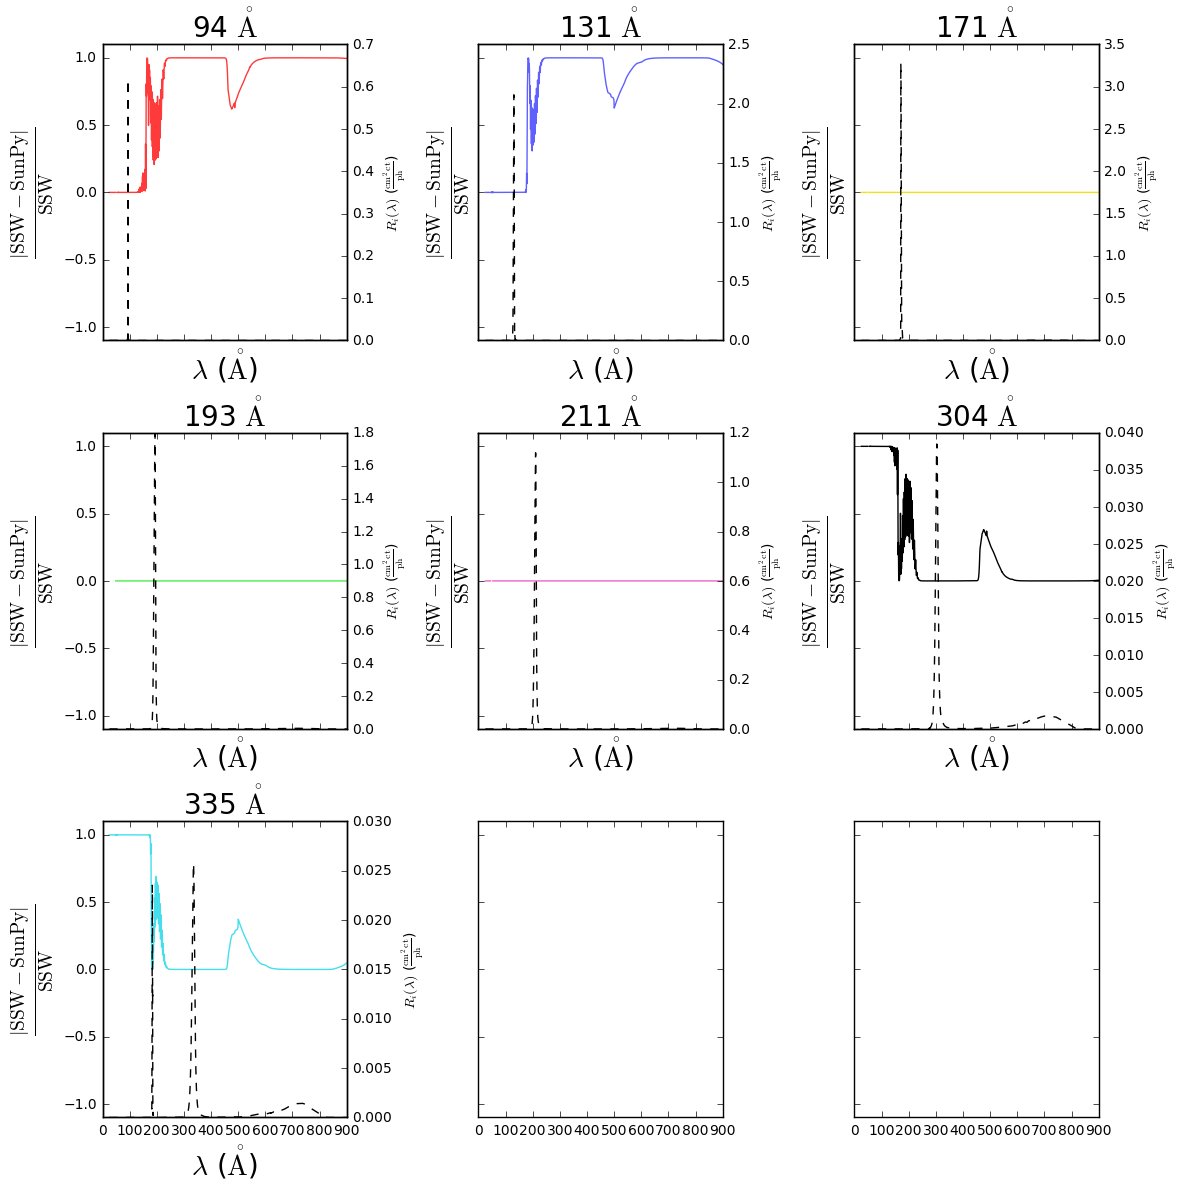

In [5]:
fig,axes = plt.subplots(3,3,figsize=(12,12),sharey=True,sharex=True)
for c,ax in zip(channels,axes.flatten()):
    #ssw
    ax2 = ax.twinx()
    ssw_interp = ssw_results[c]['response']*response.wavelength_response[c]['response'].unit
    delta_response = np.fabs(response.wavelength_response[c]['response'] - ssw_interp)/(ssw_interp)
    ax.plot(response.wavelength_response[c]['wavelength'],delta_response,color=response.channel_colors[c])
    ax2.plot(response.wavelength_response[c]['wavelength'],response.wavelength_response[c]['response'],
            color='k',linestyle='--')
    ax.set_title('{} $\mathrm{{\mathring{{A}}}}$'.format(c),fontsize=20)
    ax.set_xlabel(r'$\lambda$ ({0:latex})'.format(response.wavelength_response[c]['wavelength'].unit),fontsize=20)
    ax.set_ylabel(r'$\frac{|\mathrm{SSW}-\mathrm{SunPy}|}{\mathrm{SSW}}$',fontsize=20)
    ax2.set_ylabel(r'$R_i(\lambda)$ ({0:latex})'.format(response.wavelength_response[c]['response'].unit))
    ax.set_ylim([-1.1,1.1])
plt.tight_layout()

Now, zooming in on the two spikes in the 335 and 304 $\mathrm{\mathring{A}}$ channels...

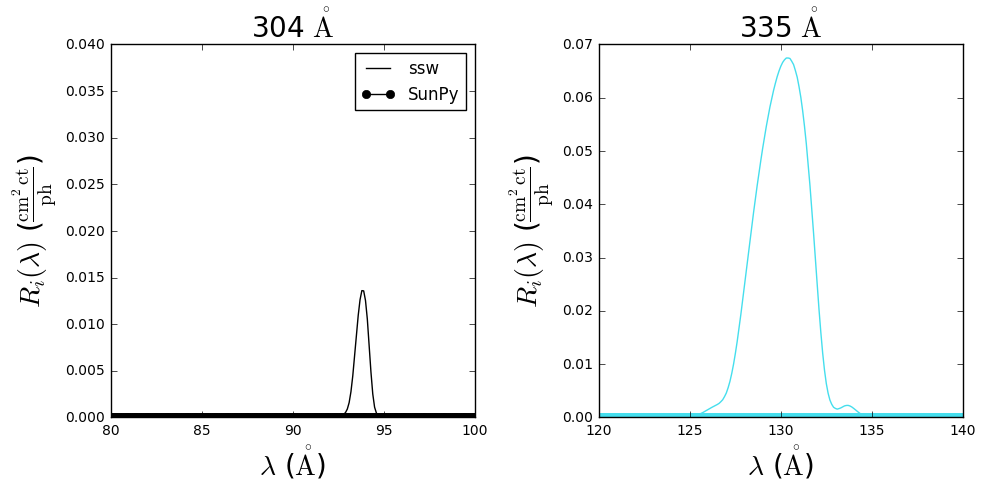

In [6]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
for c,ax in zip([304,335],axes.flatten()):
    #ssw
    ax.plot(ssw_results[c]['wavelength'],ssw_results[c]['response'],
           color=response.channel_colors[c],label='ssw')
    #sunpy
    ax.plot(response.wavelength_response[c]['wavelength'],response.wavelength_response[c]['response'],
        color=response.channel_colors[c],marker='.',ms=12,label='SunPy')
    if c==304:
        ax.set_xlim([80,100])
    if c==335:
        ax.set_xlim([120,140])
    ax.set_title('{} $\mathrm{{\mathring{{A}}}}$'.format(c),fontsize=20)
    ax.set_xlabel(r'$\lambda$ ({0:latex})'.format(response.wavelength_response[c]['wavelength'].unit),fontsize=20)
    ax.set_ylabel(r'$R_i(\lambda)$ ({0:latex})'.format(response.wavelength_response[c]['response'].unit),fontsize=20)
axes[0].legend(loc='best')
plt.tight_layout()

It looks like there is contamination from the 94 $\mathrm{\mathring{A}}$ channel in the 304 $\mathrm{\mathring{A}}$ channel and contamination from 131 $\mathrm{\mathring{A}}$ in the 335 $\mathrm{\mathring{A}}$ channel. Why? Is this a mistake or just something we haven't accounted for in the SunPy calculation? 

Now what if we test using the pre-calculated effective area loaded from the SSW genx files?

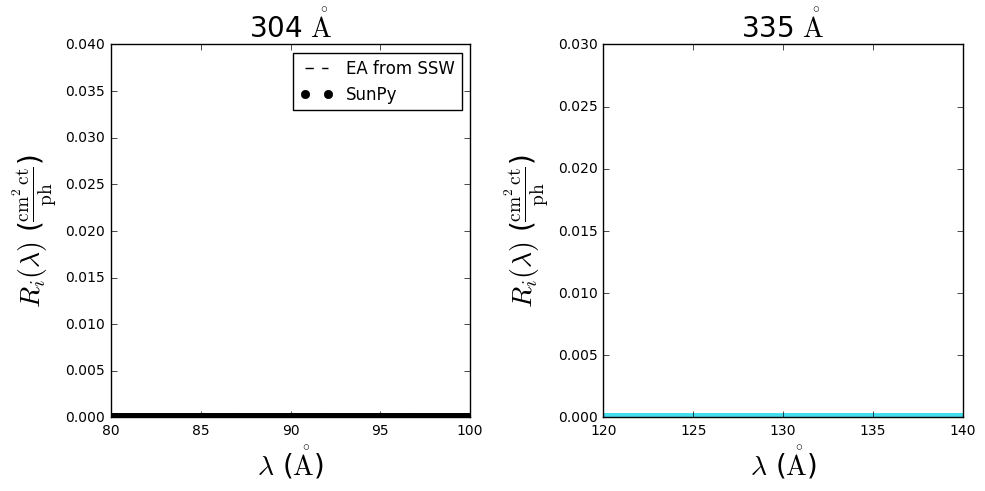

In [10]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
for ax,c in zip(axes.flatten(),[304,335]):
    wvl_response = response._channel_info[c]['effective_area']*response._calculate_system_gain(c)
    ax.plot(response.wavelength_response[c]['wavelength'],
           wvl_response,'--',color=response.channel_colors[c],label=r'EA from SSW')
    ax.plot(response.wavelength_response[c]['wavelength'],
           response.wavelength_response[c]['response'],'.',ms=12,color=response.channel_colors[c],
           label=r'SunPy')
    if c==304:
        ax.set_xlim([80,100])
    if c==335:
        ax.set_xlim([120,140])
    ax.set_title('{} $\mathrm{{\mathring{{A}}}}$'.format(c),fontsize=20)
    ax.set_xlabel(r'$\lambda$ ({0:latex})'.format(response.wavelength_response[c]['wavelength'].unit),fontsize=20)
    ax.set_ylabel(r'$R_i(\lambda)$ ({0:latex})'.format(response.wavelength_response[c]['response'].unit),fontsize=20)
axes[0].legend(loc='best')
plt.tight_layout()

Interestingly, there's also nothing showing up here, even using the effective area _included_ in the genx files.

## Temperature Response